In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from gaussian_process_regression_utils import get_posterior_mean_cov

# Data

In [3]:
df = pd.read_csv("weight_data.tsv", sep="\t")

In [4]:
#df = df.sample(10)

In [5]:
df["date"] = pd.to_datetime(df["date"])
df.head()

,date,weight,before_breakfast,after_toilet
0,2021-01-17,94.0,False,False
1,2021-01-24,95.0,False,False
2,2021-01-31,95.3,False,False
3,2021-02-07,94.8,False,False
4,2021-02-14,95.9,False,False


In [6]:
df["day"] = (df.date - df.date.min()).dt.days
df.head()

,date,weight,before_breakfast,after_toilet,day
0,2021-01-17,94.0,False,False,0
1,2021-01-24,95.0,False,False,7
2,2021-01-31,95.3,False,False,14
3,2021-02-07,94.8,False,False,21
4,2021-02-14,95.9,False,False,28


<AxesSubplot:xlabel='date', ylabel='weight'>

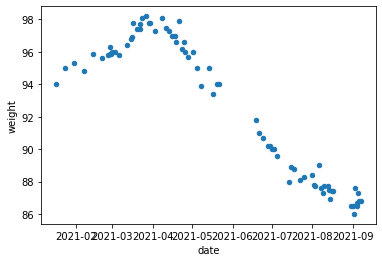

In [7]:
df.plot(x="date", y="weight", kind="scatter")

# Inference
https://docs.pymc.io/pymc-examples/examples/gaussian_processes/GP-MaunaLoa2.html#Example:-Mauna-Loa-CO_2-continued

Denote by $x_1$ the observed times, $y_1$ the weight measurements, $f_1$ the real weights at the times $x_1$ and similarly $x_2, f_2$ the unobserved times and ideal weights.

In [10]:
import arviz as az
import pymc3 as pm

WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [11]:
x1 = np.array(df.day)
y1 = np.array(df.weight)
x2 = np.linspace(df.day.max(), df.day.min(), 100)

In [12]:
help(pm.gp.Marginal)

Help on class Marginal in module pymc3.gp.gp:

class Marginal(Base)
 |  Marginal(mean_func=<pymc3.gp.mean.Zero object at 0x0000011BCDE3B5C8>, cov_func=<pymc3.gp.cov.Constant object at 0x0000011BCDE3B608>)
 |  
 |  Marginal Gaussian process.
 |  
 |  The `gp.Marginal` class is an implementation of the sum of a GP
 |  prior and additive noise.  It has `marginal_likelihood`, `conditional`
 |  and `predict` methods.  This GP implementation can be used to
 |  implement regression on data that is normally distributed.  For more
 |  information on the `prior` and `conditional` methods, see their docstrings.
 |  
 |  Parameters
 |  ----------
 |  cov_func: None, 2D array, or instance of Covariance
 |      The covariance function.  Defaults to zero.
 |  mean_func: None, instance of Mean
 |      The mean function.  Defaults to zero.
 |  
 |  Examples
 |  --------
 |  .. code:: python
 |  
 |      # A one dimensional column vector of inputs.
 |      X = np.linspace(0, 1, 10)[:, None]
 |  
 |     

In [39]:
with pm.Model() as model:
    y_one_point_mean = 87
    y_one_point_std = 10
    noise_std = pm.Lognormal("noise_std", mu=1, sigma=0.5)
    gauss_process_length_scale = pm.Lognormal("length_scale", mu=np.log(100), sigma=np.log(10))
    
    cov_func = y_one_point_std**2 * pm.gp.cov.ExpQuad(input_dim=1, ls=gauss_process_length_scale)
    mean_func = pm.gp.mean.Constant(y_one_point_mean)
    
    gauss_process = pm.gp.Marginal(mean_func, cov_func)
    f1 = gauss_process.marginal_likelihood(name="f1", X=x1[:, None], y=y1, noise=noise_std)

In [40]:
with model:
    trace = pm.sample(target_accept=0.95, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
d:\git\bordel\python_bordel_01\venv\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: divide by zero encountered in log
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
d:\git\bordel\python_bordel_01\venv\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: invalid value encountered in multiply
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
d:\git\bordel\python_bordel_01\venv\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: invalid value encountered in log
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [length_scale, noise_std]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 11513 seconds.


array([[<AxesSubplot:title={'center':'noise_std'}>,
        <AxesSubplot:title={'center':'noise_std'}>],
       [<AxesSubplot:title={'center':'length_scale'}>,
        <AxesSubplot:title={'center':'length_scale'}>]], dtype=object)

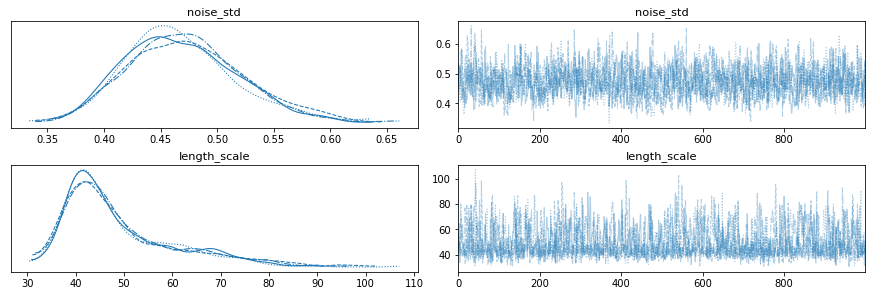

In [41]:
az.plot_trace(trace, var_names=["noise_std", "length_scale"], compact=True)

<AxesSubplot:>

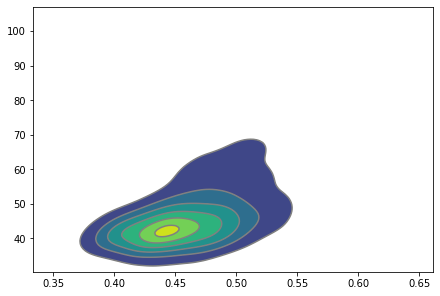

In [62]:
az.plot_kde(trace.posterior.noise_std, trace.posterior.length_scale)

In [63]:
trace.posterior

<xarray.Dataset>
Dimensions:       (chain: 4, draw: 1000)
Coordinates:
  * chain         (chain) int32 0 1 2 3
  * draw          (draw) int32 0 1 2 3 4 5 6 7 ... 993 994 995 996 997 998 999
Data variables:
    noise_std     (chain, draw) float64 0.4626 0.4801 0.5216 ... 0.4936 0.4811
    length_scale  (chain, draw) float64 50.92 54.9 47.28 ... 44.3 41.8 44.75
Attributes:
    created_at:                 2021-09-30T14:59:03.850870
    arviz_version:              0.11.2
    inference_library:          pymc3
    inference_library_version:  3.11.4
    sampling_time:              11513.177552223206
    tuning_steps:               1000